# Modeling Disability-Adjusted Life Years for Policy and Decision

Analysis

## 1 Introduction

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'expm'

The following object is masked from 'package:Matrix':

    expm


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

here() starts at /Users/johngraves/Dropbox/Projects/dalys


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.
      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and
      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

Disability-adjusted life years (DALYs) measure disease burden in a population. Conceptualized in the Global Burden of Disease (GBD) study ([C. J. Murray and Lopez 1997](#ref-Murray1997)), DALYs quantify the total sum of years of life lost due to disability attributable to a disease (YLD), plus years of life lost to premature mortality from the disease (YLL; i.e., DALY = YLD + YLL).

In addition to their role in describing levels and trends in disease burdens worldwide, DALYs are a primary health outcome in evaluations of health interventions in low- and middle-income countries (LMICs). In these settings, resource allocation decisions are guided by modeled assessments of the incremental costs per DALY averted under alternative (often competing) strategies to improve population health.[1]

Despite the prominent role of DALYs in global health policy, scant methodological guidance is available for adapting and/or structuring decision analytic models for DALY outcomes. This methodological gap has its roots in health economics education, where textbooks and training exercises focus almost exclusively on Quality-Adjusted Life Year (QALY) outcomes—the primary health outcome used for health technology assessments (HTAs) and policy decisionmaking in high-income countries (HICs). DALYs differ from QALYs in important and model-relevant respects, including the use of reference life tables to calculate YLLs and standardized disability weights to calculate YLDs.[2] To the extent DALY-specific modeling considerations are taught, they are often considered in isolation and without a firm methodological grounding in *how* one might structure a model to measure DALY outcomes.

As a consequence, and in practice, health economic applications often resort to shortcuts and other “hacks” for calculating DALYs. For example, practitioners may simply estimate a “QALY-like” DALY that is based on a diseased state occupancy payoff of one minus the disability weight. Other approaches define a diseased-state payoff using the disability weight as an estimate of YLDs, and accumulate person-years in an absorbing death state (due to disease) as an estimate of YLLs. As this study will show, these shortcuts do not provide an accurate representation of DALY levels in a population.

This study outlines methods for direct incorporation of DALY outcomes in common decision modeling environments. Our primary focus is on discrete-time Markov cohort models—however, our framework extends directly to microsimulation and is also easily adapted for continuous time discrete event simulation (DES) models. As such, our study provides a comprehensive roadmap for incorporating DALY outcomes into common decision modeling frameworks.

To maintain consistency within the literature, we build on an existing didactic disease progression model ([Alarid-Escudero et al. 2023](#ref-alarid2023introductory)). The underlying discrete time Markov cohort model is time homogeneous—that is, transition probabilities do not vary as a function of age/time in model. However, our methods and code are developed to accommodate time-inhomogeneous models. Finally, recognizing the wide spectrum of experience and programming comfort level among practitioners, we offer three approaches for modeling DALYs (beginner, intermediate and advanced) and provide replication materials for implementing our approaches in R and Microsoft Excel.

## 2 Background

This section provides background information sufficient for conceptual understanding of DALYs and how to estimate them in a decision-analytic model; it is not intended as a comprehensive treatment of the subject. For extensive discussion of the history, assumptions and controversies around DALYs, see TK.

DALYs are the sum of two components: a morbidity component called years lost to disability (YLD), and a premature mortality component called years of life lost to disease (YLL) ([WHO 2013](#ref-who2020methods)). To quantify YLDs, conditions are assigned disability weights ($D$) ranging from zero to one, with zero representing the absence of the condition and one representing the highest burden a condition can inflict. Disability weights are elicited from expert panels, are standardized across geographies, and are routinely updated and published as part of the GBD ([WHO 2013](#ref-who2020methods)).

For a given condition $c$, YLDs are defined as the condition’s disability weight multiplied by the average number of years a person lives with the disease ($L_c$):

<span id="eq-yld1">$$
YLD(c) = D_c \cdot L_c
 \qquad(1)$$</span>

YLLs are determined by a loss function, which is typically defined as the number of years lost to premature mortality. This value is often taken from a life table that provides information on remaining life expectancy at age $a$,

<span id="eq-yll1">$$
YLL(a)= Ex(a)
 \qquad(2)$$</span> .

Choices over the specific value of remaining life expectancy will depend on the context and research question at hand ([Anand and Reddy 2019](#ref-anand2019)). Historically, the GBD has utilized an *exogenous*, external reference life table based on the maximum potential life span among humans ([WHO 2013](#ref-who2020methods); [Global Burden of Disease Collaborative Network 2021](#ref-globalburdenofdiseasecollaborativenetwork2021)). More recent GBD estimates draw on reference life tables based on the lowest observed age-specific mortality rates among geographies with populations over 5 million in 2016 ([Global Burden of Disease Collaborative Network 2021](#ref-globalburdenofdiseasecollaborativenetwork2021)).

Finally, DALYS are simply the sum of these two components:

<span id="eq-daly">$$
DALY(c,a) = YLD(c) + YLL(a)
 \qquad(3)$$</span>

### 2.1 Discounting

In the original GBD study, additional age-weighting and time discounting practices were applied to DALY calculations ([C. J. Murray and Lopez 1997](#ref-Murray1997)). These methods respectively weighted the burden of illness more during adulthood than early childhood and old age, and valued present health over future years of illness by discounting YLD and YLL measures by 3% per year. From 2010 onwards, both practices were discontinued to make the DALY a more descriptive measure ([WHO 2013](#ref-who2020methods)).

While the GBD no longer uses age and time discounting, the World Health Organization’s Choosing Interventions that are Cost-Effective (WHO-CHOICE) program recommends consideration of time discounting of health outcomes ([C. J. L. Murray et al. 2020](#ref-murray2020); [Bertram et al. 2021](#ref-bertram2021)). We therefore adopt the WHO-CHOICE recommendation and include discounting in our DALY modeling approach.[3] We do, however, maintain the continuous-time discounting used in the original GBD DALY equations—which differs slightly from the more common use of discrete time discounting in Markov cohort models.

For an annual discount rate $r$, for condition $c$, and at age $a$, the equation for YLDs is,

<span id="eq-yld">$$
YLD(c) = D_c  \left ( \frac{1}{r}\left(1-e^{-r(L_c) }\right) \right ).
 \qquad(4)$$</span>

Similarly, YLLs are calculated as,

<span id="eq-yll">$$
YLL(a)= \frac{1}{r}\left(1-e^{-r Ex(a)}\right).
 \qquad(5)$$</span>

It is important to note that the discounting shown in <a href="#eq-yld" class="quarto-xref">Equation 4</a> and <a href="#eq-yll" class="quarto-xref">Equation 5</a> yields the present value of YLD and YLL outcomes at a single point in time, when the duration of disease ($L_c$) and time of death from disease ($a$) are known. For a decision model where not all cohort members start off ill, that point in time very likely occurs at some point after the baseline period—and different illness durations and death times will, of course, occur across individuals in a modeled cohort. As such, we must discount YLL and YLD outcomes further, to time $t=0$ period. This additional discounting step will become apparent in <a href="#sec-outcomes" class="quarto-xref">Section 5</a> below.

## 3 Model Overview

We build on an existing progressive disease model in which healthy individuals develop a disease with two health states (“Sick” and “Sicker”; Alarid-Escudero et al. ([2023](#ref-alarid2023introductory))). Individuals can also transition to an absorbing death state due to causes unrelated to the disease (i.e., “background” mortality), or due to disease-specific causes.

We consider outcomes under four strategies:

-   A **Standard of Care** strategy based on the baseline model parameters.
-   **Strategy A**, which improves the quality of life among individuals with the disease, but does not affect disease progression.
-   **Strategy B**, which reduces the rate of progression from Sick to Sicker by 40%.
-   **Composite Strategy AB**, which jointly implements strategies A and B.

A state transition diagram is shown in <a href="#fig-model1" class="quarto-xref">Figure 1</a>. In the figure, nodes are health states and edges depict transitions among them. Edge labels are defined in terms of transition intensities (rates). Other key model parameters are summarized in <a href="#tbl-params" class="quarto-xref">Table 1</a>.

As depicted in <a href="#fig-model1" class="quarto-xref">Figure 1</a>, and as parameterized in our replication code, the underlying Markov model is time homogeneous—that is, transition rates do not vary as a function of age/time. This is merely a simplification that builds on an existing time-homogeneous model constructed for didactic purposes ([Alarid-Escudero et al. 2023](#ref-alarid2023introductory)). We do, however, index all formulas and other model-relevant objects with the subscript $t$ to allow for time-inhomogenous models. Our replication code is also written to accommodate time-inhomogeneous models.

An additional assumption is worth highlighting. In our model, disability weights are defined as one minus the utility weight. This is not generally the case, as DALY disability weights are derived from expert valuations and are standardized across countries and regions ([WHO 2013](#ref-who2020methods); [Sassi 2006](#ref-sassi2006calculating)). Utility weights, by contrast, are often derived from general population and/or patient samples and therefore differ across geographies ([Sassi 2006](#ref-sassi2006calculating)). We have elected to parameterize our model in this way to hold this methodological difference fixed—that is, we aim to show how differences in methodological choices shape estimates of DALYs while holding fixed *additional* differences that might occur due to differences in the derivation of disability and utility weights.

<figure id="fig-model1">

<figcaption>Figure 1: State transition diagram for progressive disease model</figcaption>
</figure>

[1] The adoption of DALYs over other common health outcomes in health economics (e.g., quality-adjusted life years, or QALYs) stems from several practical and theoretical considerations. See Feng et al. ([2020](#ref-Feng2020)) and Wilkinson et al. ([2016](#ref-Wilkinson2016)) for further discussion.

[2] In contrast, QALYs are calculated based on utility weights derived from general and patient surveys. See Feng et al. ([2020](#ref-Feng2020)) and Wilkinson et al. ([2016](#ref-Wilkinson2016)) for further discussion.

[3] Practitioners who do not wish to discount DALY outcomes can simply set the annual discount rate $r$ to zero.

In [ ]:
library(tidyverse)
library(MASS)
library(expm)
library(knitr)
library(kableExtra)
options(scipen = 5) 
transpose <- purrr::transpose
select <- dplyr::select
options(knitr.kable.NA = '')

gen_wcc <- 
  # Please Note: This function is adapted from the dampack package. 
  # https://github.com/feralaes/dampack
  function (n_cycles, method = c("Simpson1/3", "half-cycle", "none")) 
{
    if (n_cycles <= 0) {
        stop("Number of cycles should be positive")
    }
    method <- match.arg(method)
    n_cycles <- as.integer(n_cycles)
    if (method == "Simpson1/3") {
        v_cycles <- seq(1, n_cycles + 1)
        v_wcc <- ((v_cycles%%2) == 0) * (2/3) + ((v_cycles%%2) != 
                                                     0) * (4/3)
        v_wcc[1] <- v_wcc[n_cycles + 1] <- 1/3
    }
    if (method == "half-cycle") {
        v_wcc <- rep(1, n_cycles + 1)
        v_wcc[1] <- v_wcc[n_cycles + 1] <- 0.5
    }
    if (method == "none") {
        v_wcc <- rep(1, n_cycles + 1)
    }
    return(v_wcc)
}

In [ ]:
params_ <- list(
    # Treatment Strategies
    v_tx_names = c("SoC","A","B","AB"),      # treatment names
    n_tx = 4, # number of treatment strategies
    
    cycle_correction = "half-cycle",
    
    v_tr_names = c("H","S1","S2"), # transient health states
    v_ab_names = c("DOC","DS"), # absorbing health states
    n_states = 5, # total number of health states
    
    horizon = 400,  # TK 400 # model time horizon (in years)  
    r_v_disc_h  = 0.03,     # annual discount rate for health outcomes
    r_v_disc_c = 0.03,     # annual discount rate for cost outcomes
    Delta_t = 1,      # time step (1 = yearly, 1/12 = monthly, etc.)
    age0 = 25,         # age at baseline
    v_s0T = c(1,0,0,0,0), # initial state occupancy  

    r_HS1 = 0.15,   # disease onset rate
    r_S1H = 0.5,    # recovery rate
    r_S1S2 = 0.105,   # disease progression rate
    r_HD = .002,  # TK .002 # background mortality rate
    
    hr_S1 = 3.0,     # hazard rate of disease-related death from S1 state
    hr_S2 = 10.0,    # hazard rate of disease-related death from S1 state
    
    u_H = 1,           # Healthy utility weight
    u_S1 = 0.75,       # Sick utility weight
    u_S2 = 0.5,        # Sicker utility weight
    u_D = 0,           # Death utility weight

    dw_S1 = 0.25,      # Sick disability weight
    dw_S2 = 0.5,       # Sicker disability weight
    
    c_H = 2000,   # annual cost of healthy
    c_S1 = 4000,  # annual cost of S1
    c_S2 = 15000, # annual cost of S2
    c_D = 0, # annual cost of death

    c_trtA = 12000, # cost of treatment A
    u_trtA = 0.95, # utility weight for treatment A (S1 state)
    dw_trtA = 0.05,    # Disability weight for sick under treatment A
    
    c_trtB = 12000, # cost of treatment B
    hr_S1S2_trtB = 0.6, # reduction in rate of disease progression 

    df_ExR =  
      # Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 
      # (GBD 2019) Reference Life Table. Institute for Health Metrics and Evaluation (IHME); 
      # 2021. doi:10.6069/1D4Y-YQ37. Accessed November 30, 2023.
          tibble::tribble(
              ~Age, ~Life.Expectancy,
              0L,       88.8718951,
              1L,      88.00051053,
              5L,      84.03008056,
              10L,      79.04633476,
              15L,       74.0665492,
              20L,      69.10756792,
              25L,      64.14930031,
              30L,       59.1962771,
              35L,      54.25261364,
              40L,      49.31739311,
              45L,      44.43332057,
              50L,      39.63473787,
              55L,      34.91488095,
              60L,      30.25343822,
              65L,      25.68089534,
              70L,      21.28820012,
              75L,      17.10351469,
              80L,      13.23872477,
              85L,      9.990181244,
              90L,      7.617724915,
              95L,      5.922359078
          ) 
)

params <- 
    with(params_,{
        modifyList(params_,list(
            v_names_states = c(v_tr_names, v_ab_names), # health state names
            omega = horizon/Delta_t,  # Total number of cycles
            r_v_disc_h_Delta_t = r_v_disc_h * Delta_t,  # Cycle discount rate: health outcomes
            r_v_disc_c_Delta_t = r_v_disc_c * Delta_t,  # Cycle discount rate: cost outcomes
            ages = (0:(horizon/Delta_t))*Delta_t + age0,  # Age in each cycle
             # Approximation function for reference life table life expectancies:
            f_ExR = function(x) pmax(0,unname(Hmisc::approxExtrap(df_ExR$Age, df_ExR$Life.Expectancy,xout = x)$y))
        ))
    })

params$ages_trace <- params$ages
params$ages <- params$ages[-length(params$ages)] 

# Discounting vectors 

v_disc_h =  # Continuous time discounting
  exp(-params$r_v_disc_h_Delta_t  * 0:(params$omega))

v_disc_c = 
  exp(-params$r_v_disc_c_Delta_t  * 0:(params$omega))

In [ ]:
params_lut <- 
  list(
    "v_tx_names" = "Treatment strategies (vector)",
    "n_tx" = "Number of treatment strategies",
    "cycle_correction" = "Cycle correction method",
    "v_tr_names" = "Transient health state names (vector)",
    "v_ab_names" = "Absorbing health state names (vector)",
    "n_states" = "Total number of health states",
    "horizon" = "Model time horizon (years)",
    "r_v_disc_h" = "Annual discount rate for health outcomes",
    "r_v_disc_c" = "Annual discount rate for cost outcomes",
    "Delta_t" = "Time step (cycle length; 1=annual, 1/12=monthly, etc.)", 
    "age0" = "Age at baseline",
    "r_HS1" = "Transition rate: healthy to sick",
    "r_S1H" = "Transition rate: sick to healthy",
    "r_S1S2" = "Transition rate: sick to sicker",
    "r_HD" = "Transition rate: Disease-free background mortality",
    "hr_S1" = "Hazard ratio: mortality from sick state",
    "hr_S2" = "Hazard ratio: mortality from sicker state", 
    "u_H" = "Utility weight: healthy [H]",
    "u_S1" = "Utility weight: sick [S1]",
    "u_S2" = "Utility weight: sick [S2]",
    "u_D" = "Utility weight: death [D]",
    "dw_S1" = "Disability weight: sick [S1]",
    "dw_S2" = "Disability weight: sicker [S2]",
    "c_H" = "Cycle occupancy cost: healthy [H]",
    "c_S1" = "Cycle occupancy cost: sick [S1]",
    "c_S2" = "Cycle occupancy cost: sicker [S2]",
    "c_D" = "Cycle occupancy cost: death [D]", 
    "c_trtA" = "Cycle occupancy cost: treatment A [S1,S2]",
    "u_trtA" = "Utility weight: treatment A [S1]",
    "dw_trtA" = "Disbility weight: treatment A [S1]",
    "c_trtB" = "Cycle occupancy cost: treatment B [S1,S2]",
    "hr_S1S2_trtB"= "Hazard Ratio: S1 to S2 disease progression under treatment B"
  )
str_params_ <- params_ %>% map_dbl(~(length(.x)))

vec_params <- str_params_[str_params_<5 & str_params_>1] %>% names()
vec_params <- vec_params[which(vec_params!="df_ExR")]
sc_params <- str_params_[str_params_==1] %>% names()

vec_params_ <- 
  params_[vec_params] %>% 
  map(~(paste0(.,collapse=","))) %>% 
  {glue::glue("({.})'")} 
labels_params <- intersect(names(params),c(vec_params,sc_params))

names(vec_params_) = vec_params
# tibble(parameter = c(sc_params,vec_params),value = unname(c(params_[sc_params],vec_params_))) %>% 
#   mutate(value = paste0(value)) %>% 
#   mutate(label = paste0(factor(parameter,levels = labels_params, labels = params_lut[labels_params]))) %>% 
#   mutate(parameter = factor(parameter,levels = labels_params)) %>% 
#   arrange(parameter) %>% 
#   kable(col.names = c("Parameter","Value","Description")) %>% 
#   kable_styling()



set_flextable_defaults(
    font.size=10,
    theme_fun = theme_vanilla,
    padding = 6
)

ft <- tibble(parameter = c(sc_params,vec_params),value = unname(c(params_[sc_params],vec_params_))) %>% 
  mutate(value = paste0(value)) %>% 
  mutate(label = paste0(factor(parameter,levels = labels_params, labels = params_lut[labels_params]))) %>% 
  mutate(parameter = factor(parameter,levels = labels_params)) %>% 
  arrange(parameter) %>% 
  rename("Parameter Name" = parameter, "Value" = value, "Description" = label) %>% 
  flextable(cwidth = 2) %>% 
  add_footer_lines("Source: Alarid-Escudero et al. (2023) and authors' assumptions.") 

ft

## 4 Transition Matrices

With the model parameterized, we next define the matrices that govern transitions. The state transition diagram represented in <a href="#fig-model1" class="quarto-xref">Figure 1</a> is not yet well-suited to calculate DALY outcomes, however. A primary reason is that transitions to the absorbing death state capture transitions due to all causes of death. To calculate YLLs, we must separately track the timing and number of deaths *due to disease*.

To accommodate this need, several approaches are available. We categorize each based on the level of experience and skill required (beginner, intermediate, advanced):

1.  **Approach 1 (Beginner): Separate Death State**: Re-define the health states to include a separate cause-specific death state as depicted in <a href="#fig-modelDS" class="quarto-xref">Figure 2</a>.[1] We then construct a Markov trace tracking state occupancy in each cycle, and use changes in the number of cause-specific deaths across cycles to calculate YLLs.

2.  **Approach 2 (Intermediate): Non-Markovian Trackers**: Augment the transition matrices to include a non-Markovian transition state for cause-specific deaths. This approach allows for efficient calculation of YLD, YLL and DALY outcomes (often useful for microsimulation or probabilistic sensitivity analyses) because it sidesteps the need to derive a Markov trace.

3.  **Approach 3 (Advanced): Markov Chain with Rewards** Define a block matrix Markov chain with rewards for occupancy (YLDs) and disease-related death transitions (YLLs) by adapting the methods in Caswell and van Daalen ([2021](#ref-caswell2021a)). This approach is the most efficient since it solves directly for expected outcomes; it also facilitates estimation of higher order moments such as variance and skewness of DALYs in a population.

Each approach facilitates the design and execution of a decision-analytic model that correctly calculates YLD, YLL, and DALY outcomes—as well as other common outcomes such as life-years (LYs), QALYs and costs. In practice, Approaches (1) and (2) will produce identical results. Approach (3) draws on slightly different assumptions on partial health state occupancy in a cycle, but yields results quite similar to (1) and (2). We show in <a href="#sec-results" class="quarto-xref">Section 7</a> that other shortcut-based approaches previously used in the literature—such as modeling a QALY-like DALY and/or accumulating time in the absorbing death state—will not in general yield similar results.

### 4.1 Approach 1 (Beginner): Cause-Specific Death State

Under this approach, we separate out deaths from disease vs. other causes by defining a separate health state for cause-specific mortality; <a href="#fig-modelDS" class="quarto-xref">Figure 2</a> shows an updated state transition diagram.

<figure id="fig-modelDS">

<figcaption>Figure 2: State transition diagram for progressive disease model with separate cause-specific death state</figcaption>
</figure>

Transitions among health states are defined in terms of continuous rates (“intensities”) and are captured within an intensity matrix $\mathbf{Q}_t$,

<figure>
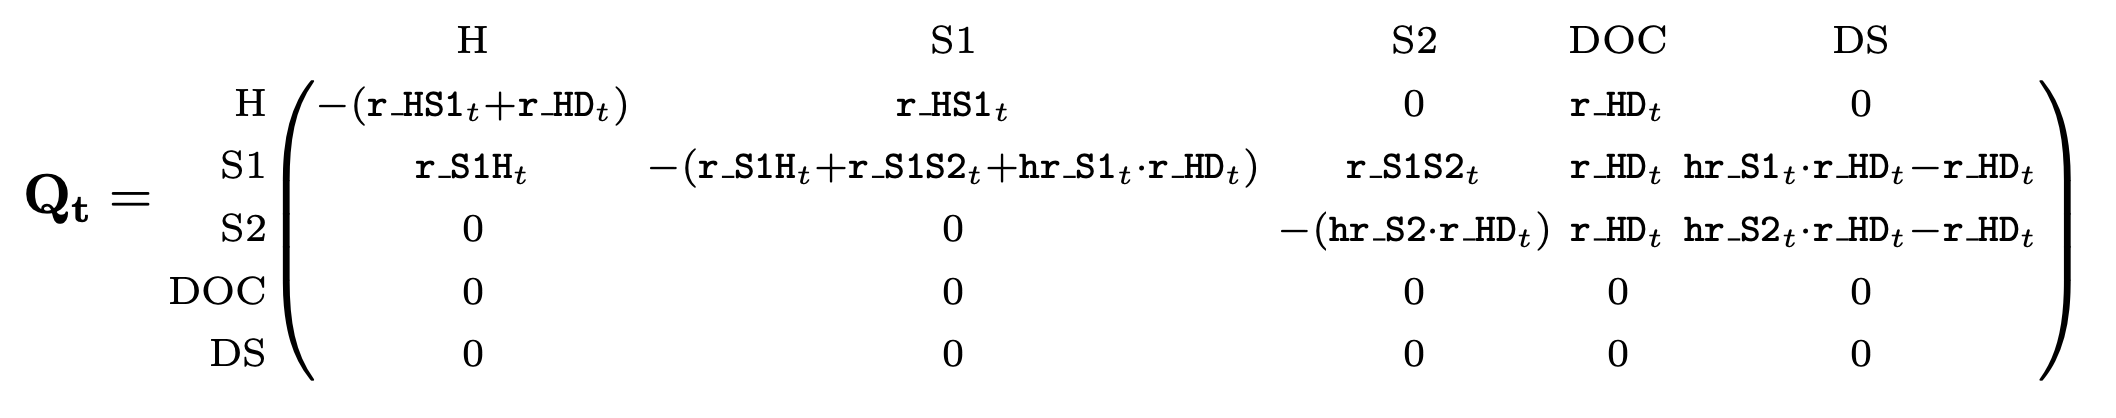
<figcaption aria-hidden="true">Transition Intensity Matrix for Approach 1</figcaption>
</figure>

Cell values in row $i$, column $j$ of $\mathbf{Q}_t$ capture the (continuous time) transition rate from health state $i$ to health state $j$. $\mathbf{Q}_t$ has diagonal elements defined as the negative sum of the off-diagonal row values (i.e., the row sums of $\mathbf{Q}_t$ are zero). This ensures that the Markov model is “closed”—that is, the total cohort size neither grows or shrinks over time.

We next embed the transition intensity matrix into a discrete time transition probability matrix by taking the matrix exponential of $\mathbf{Q}_t$ for a defined cycle length (“time step”) $\Delta t$:[2]

<span id="eq-embed">$$
\mathbf{P}_t = e^{\mathbf{Q}_t\Delta t}
 \qquad(6)$$</span>

Embedding the Sick-Sicker model results in a transition probability matrix $\mathbf{P}_t$ with the following probabilities defined:

<figure>
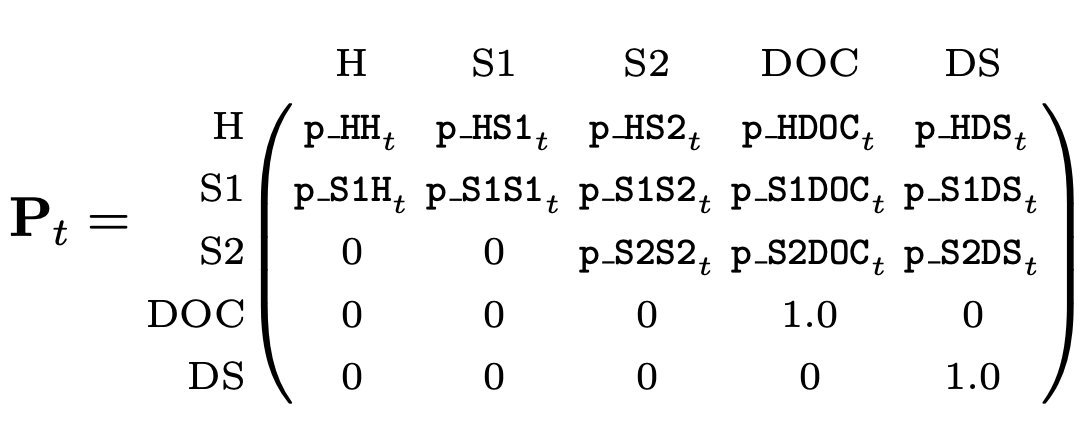
<figcaption aria-hidden="true">Transition Probability Matrix for Approach 1</figcaption>
</figure>

Embedding the transition probability matrix using <a href="#eq-embed" class="quarto-xref">Equation 6</a> ensures that the resulting transition probabilities capture the underlying continuous time disease process. In particular, $\mathbf{P}$ captures the probability of compound (“jumpover”) transitions within a single cycle.[3]

### 4.2 Approach 2 (Intermediate): Non-Markovian Tracking States

This method maintains the overall structure as depicted in the original <a href="#fig-model1" class="quarto-xref">Figure 1</a>, but augments the transition probability matrix with non-Markovian components to facilitate accounting of disease-related deaths.[4] Approach 2 offers a more generalized method that allows practitioners to accurately account for costs and/or health payoffs (such as YLLs) that are defined by *transitions* among health states, rather than occupancy in a health state. DALY outcomes can also be calculated directly, without the need to derive a vector of disease-related death transitions from the Markov trace (as required for Approach 1).

<a href="#fig-transition" class="quarto-xref">Figure 3</a> shows a state transition diagram with the tracking state added. The tracking state (shown as red nodes) simply records transitions as cohort members move from either diseased state to the absorbing death state due to causes related to the disease.

<figure id="fig-transition">

<figcaption>Figure 3: State Transition Diagram with Transition State (Red)</figcaption>
</figure>

In general, tracking states can either count the total number of transitions that have occurred up to a given cycle (i.e., an “accumulator” state), or can track the total number of new transitions that occur within a single cycle (i.e., a “transition” state).[5] To calculate YLL outcomes we will add a transition state that records the total number of new disease-related deaths in each cycle.

To implement Approach 2, we add a transition state row and column to the transition intensity matrix. This transition state, called $\texttt{trDS}$, is included in the augmented intensity matrix $\mathbf{Q}_t$ below:

<figure>
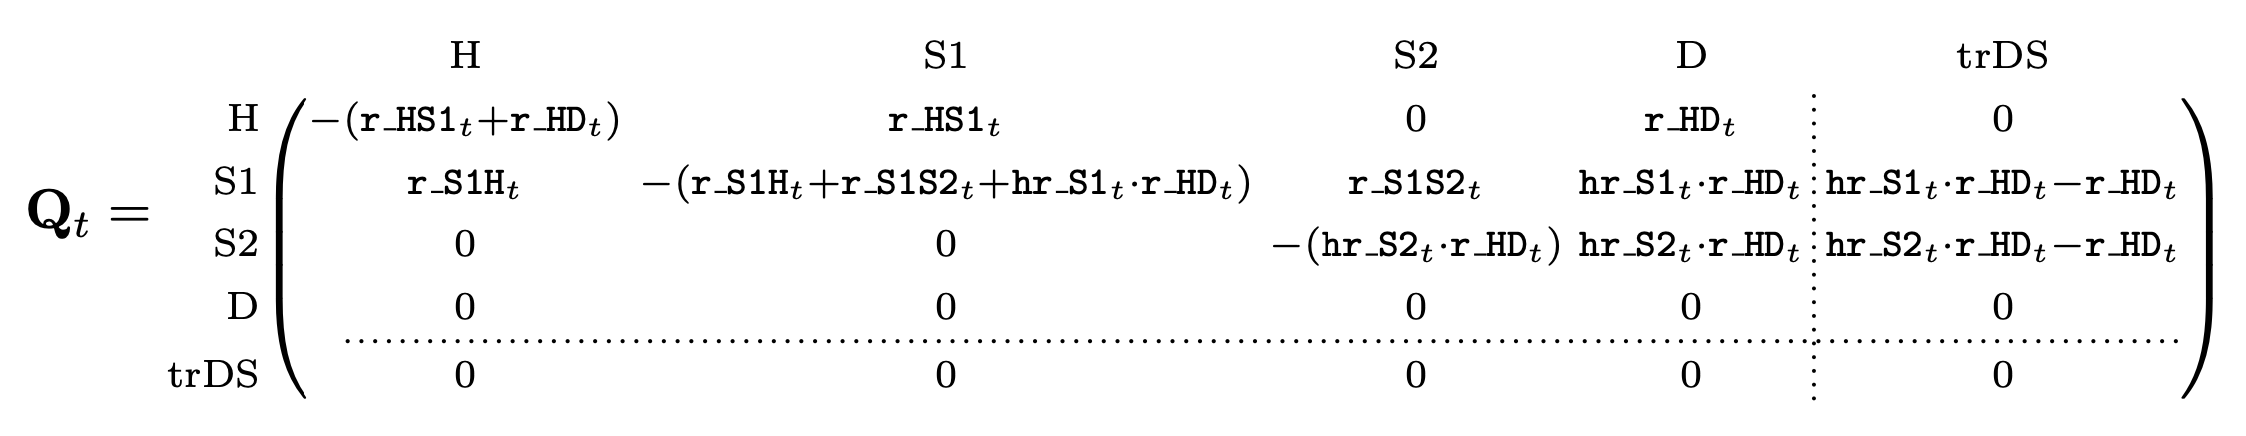
<figcaption aria-hidden="true">Transition intensity matrix with transition state added</figcaption>
</figure>

Two aspects of $\mathbf{Q}_t$ are worth highlighting. First, $\mathbf{Q}_t$ is divided into a Markovian submatrix and the non-Markovian tracking row and column. This division is made apparent using dotted vertical and horizontal lines. Critically, the Markovian submatrix remains closed—that is, the diagonal elements remain unchanged so that the row sums of the submatrix remain zero, even after the addition of the tracking column along the “edges” of $\mathbf{Q}_t$. This ensures that the Markovian submatrix can be used to calculate state occupancy for a closed cohort that neither gains nor loses cohort members over time.

Second, two transition intensities—from the S1 (Sick) and S2 (Sicker) states to Death—appear in the tracking column. This ensures that $\texttt{trDeadDisease}$ will track all relevant transitions to death due to the disease. Because we are operating on the rate scale, we can net out non-disease related deaths as captured by the background mortality rate among healthy individuals (i.e., $\texttt{r\_HD}$). Other approaches might draw on cause-deleted life tables to incorporate death transition rates that net out deaths from the disease itself.[6]

As above, we obtain the transition probability matrix by embedding $\mathbf{Q}_t$ into the discrete time step (<a href="#eq-embed" class="quarto-xref">Equation 6</a>). However, the resulting transition probability matrix treats $\texttt{trDS}$ as an absorbing state (i.e., individuals are retained in $\texttt{trDS}$ with probability one). Using the terminology introduced above, this absorbing state could serve as an **accumulator** state that (in the constructed Markov trace) records the total number of people who have died from the disease up to any given cycle. This may be a decision-relevant health outcome to consider on its own; indeed, so long as the Markovian submatrix remains closed, there is no limit to the number of accumulator and/or transition states one might add along the “edges” of a model.[7]

To change $\texttt{trDS}$ to a **transition** state, we simply replace the absorbing probability of one in the cell $[\texttt{trDS},\texttt{trDS}]$ with a zero. This cell-level change is highlighted in grey in the bottom right cell of $\mathbf{P}$ below:

<figure>
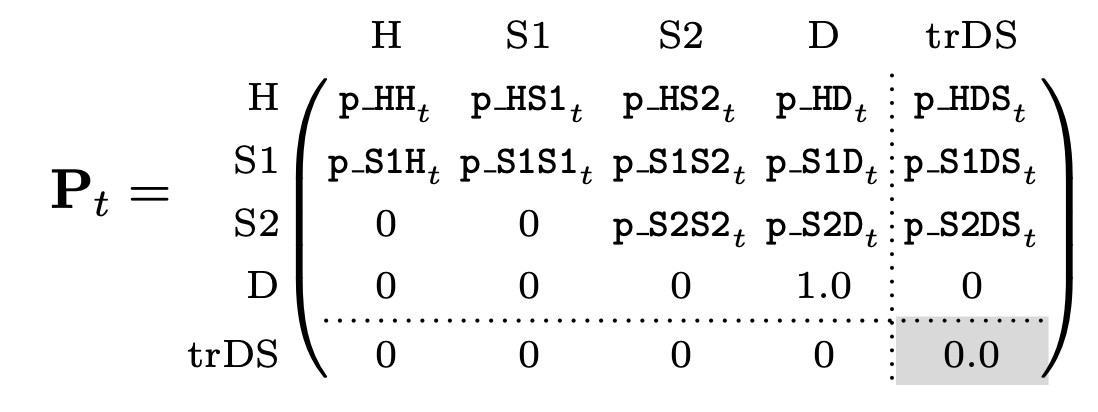
<figcaption aria-hidden="true">Transition Probability Matrix for Approach 2</figcaption>
</figure>

[1] In this example, disease-specific death rates are governed by a hazard ratio applied to the background mortality rate. Because we are operating on the rate scale, we can separate out disease-related deaths from other-cause mortality by simply taking a difference in the rates. Other applications for prevalent conditions with high death rates, however, may require us to construct a cause-deleted life table to obtain background mortality rates that net out deaths from the modeled disease.

[2] In Markov theory, $\mathbf{P}$ is called the “discrete skeleton” of the continuous model ([Iosifescu 1980](#ref-iosifescu1980)). The conversion formula used to calculate $mathbf{P}$ is the matrix analogue to the standard rate-to-probability formula commonly taught in health economics textbooks, i.e., $p = 1 - e^{r\Delta t}$, where $r$ is the rate and $\Delta t$ is the time step (i.e., “cycle length”).

[3] For example, in the continuous time rate matrix $\mathbf{Q}_t$ above, there is a zero-valued rate defined for progressions from Healthy (H) to Disease-related death (DS), since individuals must first become ill before they can die from disease-related causes. However, after embedding, the matrix $\mathbf{P}$ has a non-zero cycle transition probability from Healthy (H) to Disease-related death (DS) (i.e., $\texttt{p\_HDS}$). This value captures the probability of a compound or “jumpover” transition from Healthy and through the Sick and/or Sicker state to death from disease-related causes within the same discrete time cycle; see Graves et al. ([2021](#ref-graves2021)) for further discussion, and Iosifescu ([1980](#ref-iosifescu1980)) for additional theory.\[^comparison\]

[4] Tracking states also allow for accurate bookkeeping for other outcomes such as costs. For example, if developing the disease incurs a one-time diagnosis or treatment cost, the compound transitions implied by the embedded transition probability matrix indicate that some individuals will transiently enter (and then exit) the Sick state in a single cycle. When calculating costs, practitioners may want to include a tracking state for the Sick state to be sure to capture these one-time costs, which would be masked if cost payoffs are simply multiplied by state occupancy at the end of each cycle (e.g., costs for individuals with a sojourn through the Sick state in a single cycle would not be accounted for).

[5] More generally, accumulator and transition states can be defined for any number of transition types, as they are useful for capturing one-time costs in the model, or for for calculating other decision-relevant outcomes such as the total number of people who developed the disease or died from the disease as secondary outcomes.

[6] For an example of how to do this using Global Burden of Disease cause of death and life table data, see the [example here](https://graveja0.github.io/vchem-website/blog/posts/modeling-dalys/modeling-dalys.html)

[7] To build on the example of compound “jump-over” transitions above, suppose an individual starts off healthy in a cycle, then rapidly transitions through the Sick and Sicker state and dies due to disease-related causes within the same cycle. If there is some treatment cost associated with being in the Sicker state, a traditional approach that applies cost payoffs to state occupancy at the (beginning) end of the cycle would miss treatment costs for this individual because they *transition* through the Sicker state, but never occupy it at the beginning or end of a cycle. Adding a non-Markovian transition state to the model facilitates more accurate bookkeeping because the transition state would pick up on this transition through the Sicker state.

In [ ]:
fn_r_HD <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  r_HD
}

fn_r_HS1 <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HS1 <- get("r_HS1", envir = parent.frame())
  r_HS1
}

fn_r_S1H <- function(age) {
  # Access from the parent frame where this function is called
  r_S1H <- get("r_S1H", envir = parent.frame())
  r_S1H
}

fn_r_S1S2 <- function(age) {
  # Access  from the parent frame where this function is called
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  r_S1S2
}

params1 <- with(params,modifyList(params,list(
    # Natural History Transition Rate Matrix
    m_R = 
      ages %>% map(~({
        mR_SoC = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_A = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_B = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB * fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB *  fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_AB = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB *  fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB * fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        array(c(as.vector(mR_SoC),
                as.vector(mR_A), 
                as.vector(mR_B),
                as.vector(mR_AB)), 
              dim = c(length(v_tr_names)+ length(v_ab_names),length(v_tr_names)+ length(v_ab_names),length(v_tx_names)),
          dimnames = list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names),v_tx_names)) %>% 
            apply(.,3,function(x) x, simplify=FALSE) 
        
      }))
    )))

params1 <- with(params1,modifyList(params1,list(
    m_P = m_R %>% transpose() %>% map(~({
      mR_ = .x
      mR_ %>% map(~({
              expm(.x * Delta_t)
         }))
      }))
)))

params1 <- with(params1,modifyList(params1,list(
  m_P_ = m_P %>% map(~({
    tmp <- .x
    init <- diag(nrow=nrow(tmp[[1]]),ncol=ncol(tmp[[1]]))
    dimnames(init) = dimnames(tmp[[1]])
    append(.x,list(init),after=0)
  }))
)))
params1$m_P = params1$m_P_
params1[["m_P_"]] <- NULL

params2 <- with(params,modifyList(params,list(
    v_tr_names = c("H","S1","S2"), # transient health states
    v_ab_names = c("D","trDS"), # absorbing health states
    n_states = 5, # total number of health states
    v_names_states = c(c("H","S1","S2"), c("D","trDS"))
)))

params2 <- with(params2,modifyList(params2,list(
    # Natural History Transition Rate Matrix
    m_R = 
      ages %>% map(~({
        mR_SoC = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_A = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x) ,hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_B = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB * fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB *  fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x) ,hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_AB = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB *  fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB * fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        array(c(as.vector(mR_SoC),
                as.vector(mR_A), 
                as.vector(mR_B),
                as.vector(mR_AB)), 
              dim = c(length(v_tr_names)+ length(v_ab_names),length(v_tr_names)+ length(v_ab_names),length(v_tx_names)),
          dimnames = list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names),v_tx_names)) %>% 
            apply(.,3,function(x) x, simplify=FALSE) 
        
      }))
    )))

params2 <- with(params2,modifyList(params2,list(
    m_P = m_R %>% transpose() %>% map(~({
      mR_ = .x
      mR_ %>% map(~({
              tmp_ <- expm(.x * Delta_t)
              tmp_[5,5] = 0
              tmp_
         }))
      }))
)))

params2 <- with(params2,modifyList(params2,list(
  m_P_ = m_P %>% map(~({
    tmp <- .x
    init <- diag(nrow=nrow(tmp[[1]]),ncol=ncol(tmp[[1]]))
    dimnames(init) = dimnames(tmp[[1]])
    append(.x,list(init),after=0)
  }))
)))
params2$m_P = params2$m_P_
params2[["m_P_"]] <- NULL

### 4.3 Approach 3 (Advanced): Markov Chain With Rewards

Our final approach adapts methods from mathematical demography to estimate YLD, YLL and DALY outcomes ([Caswell and van Daalen 2021](#ref-caswell2021a)).[1] This approach requires a separate disease-related absorbing state as shown in <a href="#fig-modelDS" class="quarto-xref">Figure 2</a>. While our focus here is on expected outcomes, this method can also be used to estimate higher order moments (e.g., variance, skewness). It is also quite flexible and can estimate separate outcomes for any combination of health states and age classes (e.g., disease-free survival among those aged 40-45, etc.); see Caswell and Zarulli ([2018](#ref-caswell2018)) and Caswell and van Daalen ([2021](#ref-caswell2021a)) for details.

To implement Approach 3 we define some additional parameters:

$$
\begin{aligned}
\tau &= \text{Number of transient (non-absorbing) states}\\
\alpha &= \text{Number of absorbing states}\\
\omega &= \text{Number of cycles (age classes)} \\
s &= \text{Total number of states; }s=\tau\omega+\alpha \\
\mathbf{K} &= \text{vec-permutation matrix; parameters }\tau,\omega\\
\mathbf{U}_{t} &= \text{Transition matrix at time }t, \text{for }t=1,\dots,\omega\\
\mathbf{M}_{t} &= \text{Mortality matrix at time  }t, \text{for } t = 1,\dots\omega \\
\mathbf{D}_{j} &=\text{Age advancement matrix for stage }j, \text{for }j=1,\dots,\tau 
\end{aligned}
$$ In the above notation, $\mathbf{K}$ is a permutation matrix known as the vec-permutation matrix.[2] The matrix $\mathbf{U}_t$ captures transition probabilities among transient (i.e., non-absorbing) health states, while $\mathbf{M}_t$ contains transition probabilities from transient health states to the absorbing (death) states.

To construct $\mathbf{U}_t$ and $\mathbf{M}_t$ we define transition rate (“intensity”) matrices as in Approaches 1 and 2 above. One important (minor) difference is that the rows in $\mathbf{Q}_t$, $\mathbf{V}_t$, and $\mathbf{S}_t$ now correspond to the final state, while the columns correspond to the starting state; this is essentially the transpose of the rate matrices defined for Approaches 1 and 2.

The overall intensity matrix $\mathbf{Q}_t$ is given by

<span id="eq-Qx">$$
\mathbf{Q}_t=\left(\begin{array}{c|c}
\mathbf{V}_t & \mathbf{0} \\
\hline \mathbf{S}_t  & \mathbf{0}
\end{array}\right)
 \qquad(7)$$</span> where $\mathbf{V}_t$ is the rate matrix for the transitory (i.e., non-absorbing) states and $\mathbf{S}_t$ is the rate matrix for the absorbing states. The diagonal elements of $\mathbf{Q}_t$ are the negative sum of the non-diagonal column elements, thus making the column sums of $\mathbf{Q}_t$ zero (i.e., the model is “closed” and does not gain or lose cohort members over time).

For the defined time step $\Delta_t$, the discrete time transition probability matrix $\mathbf{P}_t$ is again obtained by taking the matrix exponential of the intensity matrix ($\mathbf{Q}_t$) multiplied by the time step, i.e., <a href="#eq-embed" class="quarto-xref">Equation 6</a>:

$$
\mathbf{P}_t =e^{\mathbf{Q}_t  \Delta t}
$$

We obtain $\mathbf{U}_t$ and $\mathbf{M}_t$ from the block matrix structure of $\mathbf{P}_t$:

<span id="eq-P3">$$
\mathbf{P}_t =\left(\begin{array}{c|c}
\mathbf{U}_t  & \mathbf{0} \\
\hline \mathbf{M}_t  & \mathbf{0}
\end{array}\right)
 \qquad(8)$$</span>

In addition, the matrix $\mathbf{D}_j$ defines age advancement in the model. Borrowing from an example in Caswell and van Daalen ([2021](#ref-caswell2021a)), if $\omega=3$ then

<span id="eq-D">$$
\mathbf{D}_j=\left(\begin{array}{ccc}
0 & 0 & 0 \\
1 & 0 & 0 \\
0 & 1 & {[1]}
\end{array}\right) \quad j=1, \ldots, \tau
 \qquad(9)$$</span>

In our implementation, we include the (optional) value of one in the lower right corner; this assumes that after the last specified age, the cohort continues to experience transitions among health states according to the transition probabilities defined for the last age class. If this value is zero, the model will assume that everyone dies after the last cycle.

We next combine the transition matrices (for all age classes as defined by discrete time cycles) together into a series of block-structured matrices as follows:

<span id="eq-bbU">$$
\mathbb{U}=\left(\begin{array}{c|c|c}
\mathbf{U}_1 & \cdots & \mathbf{0} \\
\hline & \ddots & \\
\hline \mathbf{0} & \cdots & \mathbf{U}_\omega
\end{array}\right)
 \qquad(10)$$</span>

<span id="eq-BBD">$$
\mathbb{D}=\left(\begin{array}{c|c|c}
\mathbf{D}_1 & \cdots & \mathbf{0} \\
\hline & \ddots & \\
\hline \mathbf{0} & \cdots & \mathbf{D}_\tau
\end{array}\right)
 \qquad(11)$$</span>

<span id="eq-Utilde">$$
\widetilde{\mathbf{U}}=\mathbf{K}^{\top} \mathbb{D} \mathbf{K} \mathbb{U} \quad \tau \omega \times \tau \omega
 \qquad(12)$$</span> where $^\top$ is the transpose operator.

We also define

<span id="eq-Mtilde">$$
\widetilde{\mathbf{M}}=\left(\begin{array}{lll}
\mathbf{M}_1 & \cdots & \mathbf{M}_\omega
\end{array}\right) \quad \alpha \times \tau \omega
 \qquad(13)$$</span>

Finally, we capture the entire Markov chain in a block transition matrix,

<span id="eq-Ptilde">$$
\widetilde{\mathbf{P}}=\left(\begin{array}{c|c}
\widetilde{\mathbf{U}} & \mathbf{0}_{\tau \omega \times \alpha} \\
\hline \widetilde{\mathbf{M}} & \mathbf{I}_{\alpha \times \alpha}
\end{array}\right) \quad(\tau \omega+\alpha) \times(\tau \omega+\alpha)
 \qquad(14)$$</span> where $\mathbf{I}$ is the identity matrix and $\mathbf{0}$ is a matrix of zeros.

$\widetilde{\mathbf{P}}$ is the analogue to the transition matrix $\mathbf{P}_t$ (<a href="#eq-embed" class="quarto-xref">Equation 6</a>) under Approaches 1 and 2 above.

[1] The method also easily accommodates other common outcomes such as QALYs and costs.

[2] See Henderson and Searle ([1981](#ref-henderson1981)) and Appendix B in Caswell and van Daalen ([2021](#ref-caswell2021a)) for further information. A function to construct a vec-permutation matrix is provided within our replication code.

In [ ]:
params3_ <- with(params1,modifyList(params1,list(
    alpha = length(v_ab_names),
    tau = length(v_tr_names), 
    s = length(v_tr_names)*omega + length(v_ab_names) #total number of states;s=τω+α
)))
params3_ <- with(params3_,modifyList(params3_,list(
  m_R_t = m_R %>% map(~({
    tmp <- .x
    tmp %>% map(~(t(.x)))
  }))
)))

params3 <- with(params3_, modifyList(params3_, list(m_R_ = m_R_t %>% transpose())))
params3$m_R = params3$m_R_

params3 <- with(params3,modifyList(params3,list(
    m_V = m_R %>% map(~({
            R = .x
            R %>% map(~({
              m <- .x[v_tr_names,v_tr_names] 
            }))
            
        })),
     
    m_Q = m_R %>% map(~({
      R = .x 
      R %>% map(~({
                V = .x[v_tr_names,v_tr_names]
                S = .x[v_ab_names,v_tr_names]
                zero_ <- matrix(0, nrow = length(v_tr_names)+length(v_ab_names), ncol = length(v_ab_names))
                tmp <- cbind(rbind(V,S),zero_)
                dimnames(tmp) <- list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names))
                tmp
      }))
    }))    
)))

params3 <- with(params3,modifyList(params3,list(
    m_P3 = m_Q %>% map(~({
          Q = .x
          Q %>% map(~(expm(.x * Delta_t)))
    }))
)))
params3$m_P = params3$m_P3

params3 <- with(params3,modifyList(params3,list(
    m_U = m_P %>% map(~({
          P <- .x 
          P %>% map(~(.x[v_tr_names,v_tr_names]))
    })),
    m_M = m_P %>% map(~({
        P = .x
        P %>% map(~(.x[v_ab_names,v_tr_names]))
        
    }))
)))

params3 <- with(params3,modifyList(params3,list(
    D = {
        # Create diagonal age advancement matrix
        D <- matrix(0, omega, omega)
        vec <- rep(1, omega-1)
        D[row(D)-1 == col(D)] <- vec
        D[omega,omega] = 1
        D
    }
)))

vec <-  # a simple function to return the vec of an array
    function(x) {
        y <- c(x)
        return(y)
    }

vecperm <- 
    # vecperm
    # function to calculate the vec permutation matrix K of index m,n
    # let X be a m x n matrix, and X' the transpose of X
    # then K satisfies 
    # vec(X') = K*vec(X)
    function(m, n) {
        K <- matrix(0, m * n, m * n)
        a <- matrix(0, m, n)
        
        for (i in 1:m) {
            for (j in 1:n) {
                e <- a
                e[i, j] <- 1
                K <- K + kronecker(e, t(e))
            }
        }
        return(K)
    }

params3 <- with(params3,modifyList(params3,list(
    bbD_ = kronecker(diag(tau), D),
    bbU_ =  m_U %>% 
            map(~(bdiag(.x))),
    K = vecperm(tau, omega)
)))

params3 <- with(params3,modifyList(params3,list(
    mUtilde = bbU_ %>% map( ~ ({
        t(K) %*% bbD_ %*% K %*% .x
    }))
)))

params3 <- with(params3,modifyList(params3,list(
    mMtilde = m_M %>% map(~({
      do.call(cbind,.x) 
    }))  
)))

params3 <- with(params3,modifyList(params3,list(
    mPtilde =  map2(mUtilde, mMtilde,  ~ ({
            rbind(cbind(.x, matrix(0, tau * omega, alpha)) ,
                  cbind(.y, diag(alpha)))
        }))
)))

# Markov chain with rewards functions

mcwr_occupancy <- function(params, H, V) {
    with(params,{
        map(v_tx_names,~({
            U = mUtilde[[.x]]
            P = mPtilde[[.x]]
            v_ = V[[.x]]
            N = solve(diag(tau*omega)-U)
            h = vec(H) %>% as.matrix()
            not_h = 1-h
            v <- vec(v_) %>% as.matrix()
            B1 <- h %*% t(v) + 0.5 * (not_h %*% t(v)) + 0.5 * (v %*% t(not_h)) # Eq. 46
            C1 = 0.5 * (rep(1,alpha) %*%  t(v)) # Eq. 48
            R1 = rbind(cbind(B1, matrix(0, tau * omega, alpha)) ,
                              cbind(C1, diag(alpha))) 
            R2 = R1 * R1
            R3 = R1 * R1 * R1
            Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
            e = rep(1,s)
            rho1_ <- t(N)%*% Z %*% t(P * R1) %*% e
            rho1_
        }))
    })
}

mcwr_yll <- function(params, life_expectancy, disc) {
    with(params,{
        map2(mUtilde,mPtilde,~({
            U = .x
            P = .y
            N = solve(diag(tau*omega)-U)
            Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
            disc_ = rev(sort(rep(disc,length(v_tr_names))))
            eta1_ex_ = rev(sort(rep(life_expectancy,length(v_tr_names))))
            eta1_ex =  eta1_ex_
            
            B1 = matrix(0,nrow=tau*omega, ncol = tau*omega)
            C1 = rbind(matrix(0,nrow=1,ncol=tau*omega),eta1_ex*disc_) 
            R1 = cbind(rbind(B1,C1),matrix(0,nrow=tau*omega+2,ncol=2))
            R2 = R1 * R1
            R3 = R1 * R1 * R1
            Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
            e = rep(1,s)
            rho1_ = t(N) %*% Z %*% t(.y * R1) %*% e
            rho1_
        }))
    })
}

## 5 DALY Outcomes Under Approaches 1 and 2

With transition matrices and other relevant model objects defined, we next define formulas for estimating outcomes. Our three approaches differ in how total (or expected) outcomes are calculated. Approach 1 requires a Markov trace that tracks occupancy in each cycle; for YLL outcomes, we use this information to calculate the number of new disease-related deaths in each cycle. Approach 2 does not require this extra step, as both cycle-specific and total outcomes are calculated directly. Finally, Approach 3 differs insofar as it directly solves for expected outcomes (i.e., the approach does not require calculation of cycle-specific values).

### 5.1 Markov Trace

YLL outcomes calculated under Approach 1 requires a Markov trace, or a matrix summarizing occupancy in each health state in each cycle. Define $\mathbf{s}_0$ as the initial state occupancy (column) vector at time $t=0$. The vector $\mathbf{s}_0$ has size $k$, where $k$ is the total number of states (including transition tracking states, if applicable). This vector summarizes the number or fraction of the cohort in each health state at baseline. Health state occupancy at time $t$ is is calculated as:

<span id="eq-trace">$$
\mathbf{s}^\top_t=\mathbf{s}^\top_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t
 \qquad(15)$$</span> where $\mathbf{P}_t$ is the $k \times k$ transition probability matrix at time $t$.[1]

We apply <a href="#eq-trace" class="quarto-xref">Equation 15</a> at each cycle to construct a Markov trace $\mathbf{S}$, which has dimensions $\omega \times k$,

<span id="eq-markovtrace">$$
\mathbf{S} = \begin{bmatrix}
s_{01} & s_{02} & \ldots & s_{0k} \\
s_{11} & s_{12} & \ldots & s_{1k} \\
\vdots & \vdots & \ddots & \vdots \\
s_{\omega-1, 1} & s_{\omega-1, 2} & \ldots & s_{\omega-1, k}
\end{bmatrix}
 \qquad(16)$$</span> where each row represents state occupancy at time $t = 0, 1, \ldots, \omega-1$.

Note that the rows in $\mathbf{S}$ run from $t=0$ to $\omega-1$; this assumes that all health state transitions occur at the end of each cycle. If we were to instead assume transitions occur at the beginning of the cycle, we would set the matrix to run from $t=1$ to $\omega$.

### 5.2 Years of Life Lived with Disability (YLD)

To calculate YLDs, we define a $k \times 1$ disability weight payoff vector $\mathbf{d}_{YLD}$. For the model as represented in <a href="#fig-modelDS" class="quarto-xref">Figure 2</a>, define,

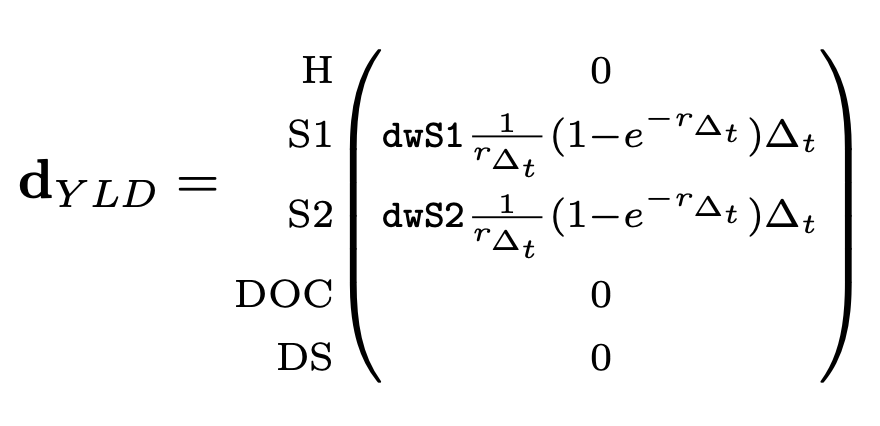

where $\texttt{dwS1}$ and $\texttt{dwS2}$ are the disability weights for the Sick and Sicker states, respectively. In addition, $r_{\Delta_t}$ is the cycle discount rate, which is calculated as,

<span id="eq-cycledisc">$$
r_{\Delta_t} = r \Delta_t
 \qquad(17)$$</span> where $r$ is the annual discount rate and $\Delta_t$ is the cycle length.

In the YLD payoff vector, the term $\frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}})$ is included as a continuous-time discounting factor for the defined time step $\Delta_t$. This term is included to discount time *within* each cycle in order to maintain the continuous-time discounting approach used in the original GBD equations ([Larson 2013](#ref-larson2013calculating)).[2]

To fully discount outcomes, we still must discount all future outcome values back to baseline ($t=0$). Discounted years of life lost to disability (YLD) at cycle $t$ is given by

<span id="eq-yldt">$$
YLD_t=\mathbf{s}'_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLD}  \times{e^{-r_{\Delta_t} t}}
 \qquad(18)$$</span>

Total discounted YLDs are obtained by summing cycle-specific discounted YLD outcomes,

<span id="eq-yldcum">$$
YLD=\sum_{t=0}^{\omega-1} YLD_t
 \qquad(19)$$</span>

We can incorporate additional cycle adjustments (e.g., half-cycle adjustment or an adjustment based on Simpson’s rule) by defining a adjustment factor $c_t$ that multiplies the cycle-specific discounting factor (i.e., $e^{-r_{\Delta_t} t}$) with other cycle-specific adjustment values,

<span id="eq-yldcum2">$$
YLD=\sum_{t=0}^{\omega-1} YLD(t)=\sum_{t=0}^{\omega-1}\left(\mathbf{s}'_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLD}  \times c_t \right)
 \qquad(20)$$</span> where, at a minimum, $c_t=e^{-r\Delta_t t}$ and can also include any other cycle-correction value (e.g., 0.5 for half-cycle correction or a Simpson’s rule coefficient, etc.).

Finally, an equivalent way to calculate YLD outcomes is through matrix multiplication of the Markov trace matrix and the YLD payoff vector,

<span id="eq-yldtrace">$$
YLD = \sum_{t=0}^{\omega-1} \mathbf{S}\mathbf{d}_{YLD} \odot \mathbf{c}
 \qquad(21)$$</span> where $\mathbf{c}$ is an $\omega \times 1$ vector of cycle discounting/correction factors $c_t$ and $\odot$ is the element-wise multiplication (Hadamard product) operator.

### 5.3 Years of Life Lost to Disease (YLLs): Approach 1

As noted in <a href="#sec-background" class="quarto-xref">Section 2</a> and in <a href="#eq-yll" class="quarto-xref">Equation 5</a>, YLLs are based on the present value of remaining life expectancy among disease-related deaths. In a discrete time Markov model, these deaths may occur in any cycle—though, like YLDs, the fully-discounted value is calculated relative to baseline ($t=0$).

Define $a_{t}$ as the age of the cohort at cycle $t$, i.e.,

<span id="eq-aget">$$
a_t = a_0 +t \cdot \Delta_t 
 \qquad(22)$$</span> where $a_0$ is the age of the cohort at $t=0$.

We next define $Ex_t$ as the present value of remaining life expectancy of the cohort in cycle $t$.

Following the GBD discounting approach, $Ex_{t}$ is given by

<span id="eq-pvEx">$$
Ex_{t} = \frac{1}{r}\big (1 - e^{-rEx(a_{t})} \big )
 \qquad(23)$$</span>

where $Ex(a_t)$ is the remaining life expectancy at age $a$. $Ex(a_t)$ is drawn from either an exogenous (reference) life table, or an endogenous life table, depending on the objectives of the modeling exercise ([Anand and Reddy 2019](#ref-anand2019)).

To calculate YLLs, we use the Markov trace to calculate $m_t$, the total number of new deaths from disease-related causes in each cycle. We calculate $m_t$ by taking the difference in state occupancy in the disease-related death column (`DS`) in adjacent cycles. As above, we can incorporate additional discounting and cycle adjustments into a cycle correction term $c_t$ and calculate total discounted (and cycle-corrected) YLLs as

<span id="eq-yllt1">$$
YLL_t=m_t Ex_t  \times{c_t} 
 \qquad(24)$$</span>

Total discounted YLLs are given by,

<span id="eq-yllcum1">$$
YLL=\sum_{t=1}^{\omega-1} YLL_t = \sum_{t=1}^{\omega-1}m_t Ex_{t}  \times{c_t} 
 \qquad(25)$$</span>

### 5.4 Years of Life Lost to Disease (YLLs): Approach 2

YLLs under Approach 2 can be calculated in a similar way as YLDs, since we have augmented the model with a transition tracking state that directly estimates new deaths in each cycle. Define the YLL payoff vector $\mathbf{d}_{YLL,t}$, which has value $Ex_{t}$ for the transition tracker health state (`trDS`) and zeros elsewhere,

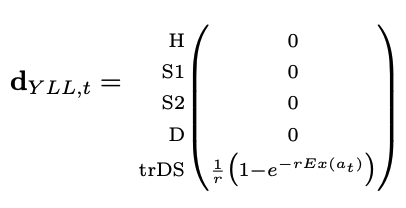

We can now apply similar equations as used for YLD outcomes to calculate fully discounted YLLs,

<span id="eq-yllcum">$$
YLL=\sum_{t=0}^{\omega-1} YLD(t)=\sum_{t=0}^{\omega-1}\left(\mathbf{s}'_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLL,t}  \times c_t \right)
 \qquad(26)$$</span>

Alternatively, using the Markov trace, we stack each $k \times 1$ payoff vector (using $\mathbf{d}_{YLL,t}^\top$ as rows) into an $\omega \times k$ payoff matrix $\mathbf{D}$, and obtain total adjusted YLLs as

<span id="eq-ylltrace">$$
YLL = \sum_{t=0}^{\omega-1} \text{sum}(\mathbf{S} \odot \mathbf{D}) \odot \mathbf{c}
 \qquad(27)$$</span> where the $\text{sum}()$ operator sums each row across the $k$ columns that result from $\mathbf{S} \odot \mathbf{D}$.

[1] For a time-homogeneous model, <a href="#eq-trace" class="quarto-xref">Equation 15</a> simplifies to $\mathbf{s}^\top_t=\mathbf{s}^\top_0 \mathbf{P}^t$.

[2] Common discounting formulas, such as the discrete time discount factor $\frac{1}{(1+r)^t}$, as well as the continuous time discount factor $e^{-rt}$, are designed for a series of discrete “payoffs” at specific time points. By comparison, the continuous time discounting used in the GBD DALY equations (<a href="#eq-yld" class="quarto-xref">Equation 4</a> and <a href="#eq-yll" class="quarto-xref">Equation 5</a>) is based on an assumption that payoffs accrue in a continuous stream. The discount adjustment factor shown here ($\frac{1}{r}(1-e^{-rt})$)—and introduced in Larson ([2013](#ref-larson2013calculating)))—essentially “smooths out” the discrete YLD weight applied in each cycle to reflect this continuous flow. We have verified that application of this factor in our approach exactly replicate the example results using the GBD equations in Fox-Rushby and Hanson ([2001](#ref-rushby2001)); see the Supplementary Appendix for these examples and code.

In [ ]:
trace1 <- 
    with(params1, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    })  

trace2 <- 
    with(params2, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    })  

In [ ]:
# YYs
ly_ = with(params1,(matrix(c(1,
              1 ,
              1,
              0,
              0) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
ly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
         ly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

LYt <- 
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- ly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

LY = LYt %>% map(~sum(.x * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# QALYs
qaly_ = with(params1,(matrix(c(u_H,
              u_S1 ,
              u_S2,
              u_D,
              u_D) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
qaly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- qaly_
          tmp_[2,1] = u_trtA * Delta_t
          tmp_
      } else qaly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

QALYt <-  
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- qaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

QALY = QALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# YLD
yld_ = with(params1,(matrix(c(0,
              dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)) ,
              dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)),
              0,
              0),
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("DW")))
))
yld_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- yld_
          tmp_[2,1] = dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
          tmp_
      } else yld_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

YLDt <- 
   with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- yld_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)
YLD = YLDt %>% map(~sum(.x*  v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction)))

# YLL
new_deaths_from_disease <- 
    map(trace1,~({
        c(0,diff(.x[,"DS"]))
    })) 

remaining_life_expectancy <- 
    with(params1,(1/r_v_disc_h) * (1 - exp(-r_v_disc_h * f_ExR(ages_trace))))
    
YLLt <- 
    new_deaths_from_disease %>% map(~(.x * remaining_life_expectancy ))

YLL <- 
    YLLt %>% map(~(sum(.x * v_disc_h * gen_wcc(params1$omega,method = params1$cycle_correction))))

DALY <- 
    map2(YLL,YLD,~(.x + .y))

# Accumulated Time in Absorbing Death State
accdaly_ = with(params1,(matrix(c(0,
              dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)) ,
              dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)),
              0,
              1) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
accdaly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- accdaly_
          tmp_[2,1] = dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
          tmp_
      } else accdaly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

ACCDALYt <- 
   with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- accdaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)
ACCDALY = ACCDALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

qaly_daly_ = with(params1,(matrix(c(u_H,
              1-dw_S1 ,
              1-dw_S2,
              u_D,
              u_D) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("QALY_DALY_")))
))
qaly_daly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- qaly_daly_
          tmp_[2,1] = (1-dw_trtA) * Delta_t
          tmp_
      } else qaly_daly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

QALY_DALYt <-    
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- qaly_daly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

QALY_DALY = QALY_DALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# Costs
cost_ = with(params1,(matrix(c(c_H,
              c_S1 ,
              c_S2,
              c_D,
              c_D)*Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("COST")))
))
cost_ <-
  with(params1, {
    v_tx_names %>% map( ~ ({
      if (.x == "A") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA)*Delta_t
        tmp_
      } else if (.x == "B") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtB)*Delta_t
        tmp_
      } else if (.x == "AB") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA + c_trtB)*Delta_t
        tmp_
      } else cost_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

COSTt <- 
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- cost_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

COST = COSTt %>% map(~sum(.x * v_disc_c * gen_wcc(params1$omega, method = params1$cycle_correction))) 

result1 <- cbind(LY, YLD, YLL, DALY, ACCDALY, QALY_DALY, QALY,COST) %>%
  as.data.frame() %>%
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Trace") %>% 
  dplyr::select(approach, strategy, everything()) 

## 6 DALY Outcomes Under Approach 3

Our advanced approach draws on Markov chain with rewards methods that define reward matrices for occupancy-based (YLD) and transition-based (YLL) outcomes. These reward matrices allow us to estimate outcomes for any combination of health states and/or ages. Reward matrices have notation $\mathbf{R}_m$, where $m$ indexes the moment of interest (e.g., expected value, variance, etc.). We focus here on expected outcomes (i.e., outcomes based on $\mathbf{R}_1$)—though equations for higher-order moments are available in Caswell and van Daalen ([2021](#ref-caswell2021a)).

### 6.1 Years of Life Lived With Disease (YLD)

To estimate YLDs, we first define a $\tau \times \omega$ reward matrix $\mathbf{H}$, which has dimensions $\tau \times \omega$ and is structured as shown in <a href="#fig-H-le" class="quarto-xref">Figure 4</a>:

<figure id="fig-H-le">
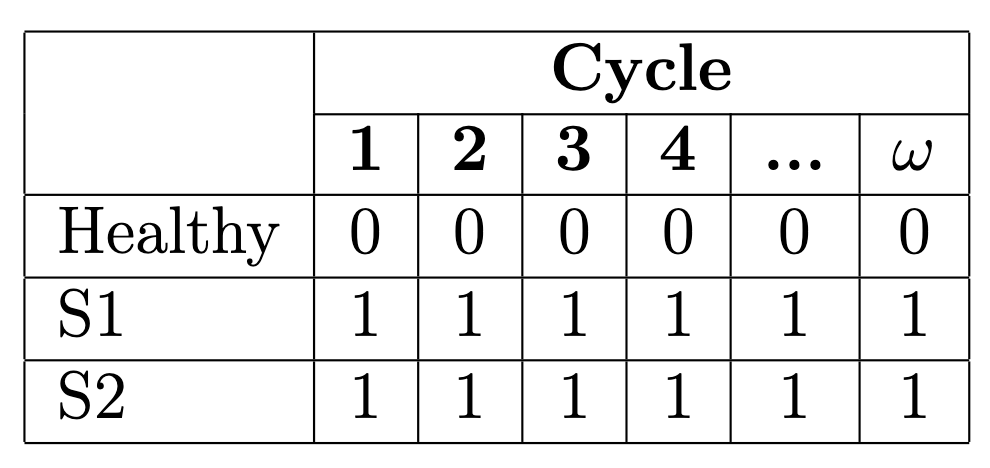
<figcaption>Figure 4: YLD reward matrix <span class="math inline">\(\mathbf{H}\)</span></figcaption>
</figure>

Cell values within this matrix can be set to one if we want to potentially “reward” that health state-age combination in our outcome measure, and zero otherwise.

We use this matrix to define the reward vector $\mathbf{h}$, where $\text{vec}$ is an operator that stacks the columns of an $m \times n$ matrix into a $mn \times 1$ vector.

$$
\mathbf{h} = \text{vec } \mathbf{H}
$$ We also define $\neg \mathbf{h}$ as the complement of $\mathbf{h}$, (i.e., values of 1.0 become 0, and vice versa).

We next define additional matrix $\mathbf{V}$, which has the same structure as $\mathbf{H}$ but includes the (fully discounted) disability weights:

<figure id="fig-H-yld">
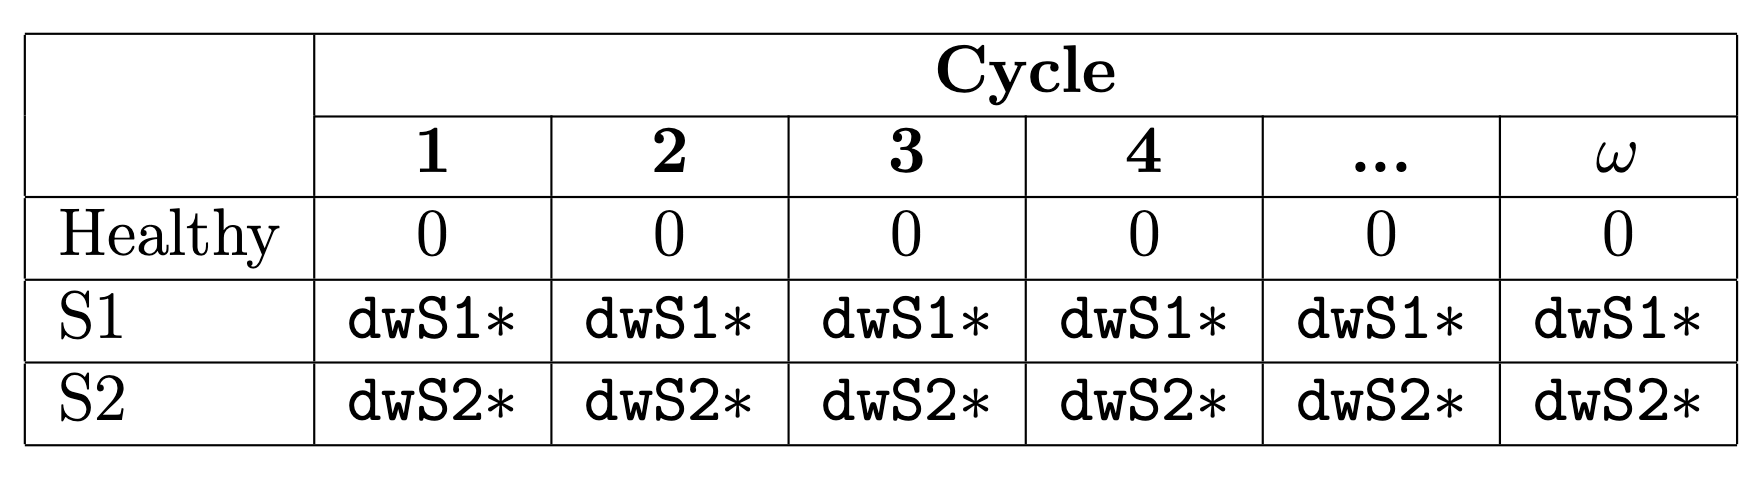
<figcaption>Figure 5: YLD reward matrix <span class="math inline">\(\mathbf{V}\)</span></figcaption>
</figure>

where $\texttt{dwS1}* = \texttt{dwS1} \times \Delta_t  \times  \frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}}) \times e^{-r_{\Delta_t} t}$, etc. This equation first converts the weights into the appropriate value for the time step, applies the cycle-specific discounting adjustment factor, and then discounts the resulting value to the baseline period.

We similarly define an occupancy indicator vector $\mathbf{v}$ just as we did for $\mathbf{h}$:

$$
\mathbf{v}=\operatorname{vec} \mathbf{V}
$$

#### 6.1.1 Partial Occupancy

Because we are modeling a continuous-time disease progression progress in discrete time, it is useful to make corrections for partial occupancy in a cycle. Similar to a half-cycle correction often used in health economic applications, the Markov chain with rewards approach does so by assuming transitions occur half-way through a cycle; the application of this assumption is slightly different, however, because the correction applies in every cycle, not just the first and last. We operationalize this assumption by defining,

$$
\begin{aligned}
\widetilde{\mathbf{B}}_{1} & =\mathbf{h} \mathbf{v}_{1}^{\top}+\frac{1}{2}(\neg \mathbf{h})\left(\mathbf{v}_{1}^{\top}\right)+\frac{1}{2}\left(\mathbf{v}_{1}\right)\left(\neg \mathbf{h}^{\top}\right) \\
\end{aligned}
$$ and

$$
\widetilde{\mathbf{C}}_{1}=\frac{1}{2} \mathbf{1}_{\alpha} \mathbf{v_1}^{\top}
$$ where $\mathbf{1}_{\alpha}$ is a vector of ones with length $\alpha$.

We combine $\widetilde{\mathbf{B}}_{1}$ and $\widetilde{\mathbf{C}}_{1}$ to obtain the final reward matrix for expected YLD outcomes,

$$
\widetilde{\mathbf{R}}^{YLD}_{1}=\left(\begin{array}{c|c}
\widetilde{\mathbf{B}}_{1} & \mathbf{0} \\
\hline \widetilde{\mathbf{C}}_{1} & \mathbf{0}
\end{array}\right) 
$$ which has same block structure and dimensions as the transition probability matrix $\widetilde{\mathbf{P}}$ (<a href="#eq-Ptilde" class="quarto-xref">Equation 14</a>). We explain how to use this matrix to estimate expected YLDs in <a href="#sec-expected" class="quarto-xref">Section 6.3</a> below.

### 6.2 Years of Life Lost to Disease (YLL)

For transition-based outcomes such as YLLs, we define the first moment of remaining life expectancy as the vector $\widetilde{\boldsymbol{\eta}}^{\top}$. This vector has dimensions $\tau\omega \times 1$ and has the following basic structure:

$$
\widetilde{\mathbf{\eta}}=\left(\begin{array}{c}
\eta_{11} \\
\vdots \\
\eta_{\tau 1} \\
\hline \vdots \\
\hline \eta_{1 \omega} \\
\vdots \\
\eta_{\tau \omega}
\end{array}\right)
$$ where $\eta_{i x}$ is remaining life expectancy for an individual in health state $i$ at a given age $x$. In this structure, remaining life expectancy for each health state is grouped within age classes. Remaining life expectancy should also enter $\eta_{i x}$ as fully discounted back to $t=0$.

Our model, for example, follows a cohort of 25 year old adults until death. The GBD reference life expectancy value for a 25 year old is 64.15, and the life expectancy for the last age class (95+) is 5.92. There are also $\tau=3$ non-absorbing health states. If we followed the cohort until age 95, $\eta_{i x}$ would take the following form:

$$
\widetilde{\mathbf{\eta}}=\left(\begin{array}{c}
\eta_{H,25} =  64.15 \\
\eta_{S1,25} =  64.15 \\
\eta_{S2,25} =  64.15 \\
\hline \vdots \\
\hline \eta_{H,95} =  5.92 \\
\eta_{S1,95} = 5.92 \\
\eta_{S2,95} =  5.92 \\
\end{array}\right)
$$

We next construct the reward matrices:

$$
\begin{aligned}
\widetilde{\mathbf{B}}_{1} & =\left(\mathbf{0}_{\tau \omega \times \tau \omega}\right) \\
\widetilde{\mathbf{C}}_{1} & =\left(\begin{array}{c}
\widetilde{\boldsymbol{\eta}}_{1}^{\top} \\
\mathbf{0}_{1 \times \tau \omega}
\end{array}\right) .
\end{aligned}
$$

and

$$
\widetilde{\mathbf{R}}^{YLL}_{1}=\left(\begin{array}{c|c}
\mathbf{0}_{\tau \omega \times \tau \omega} & \mathbf{0}_{\tau \omega \times 2} \\
\hline \widetilde{\boldsymbol{\eta}}_{1}^{\top} & \mathbf{0}_{1 \times 2} \\
\mathbf{0}_{1 \times \tau \omega} & \mathbf{0}_{1 \times 2}
\end{array}\right)
$$

### 6.3 Expected YLD and YLL Outcomes

The expected value of outcome $Y$ (where $Y \in \{YLD, YLL\}$) is estimated by,

<span id="eq-app3out">$$
\begin{aligned}
& \widetilde{\boldsymbol{\rho}}^{Y}_{1}=\widetilde{\mathbf{N}}^{\top} \mathbf{Z}\left(\widetilde{\mathbf{P}} \odot \widetilde{\mathbf{R}}^Y_{1}\right)^{\top} \mathbf{1}_{s} 
\end{aligned}
 \qquad(28)$$</span> where $\widetilde{\mathbf{N}}$ is the fundamental matrix,

$$
\widetilde{\mathbf{N}}=(\mathbf{I}-\widetilde{\mathbf{U}})^{-1}
$$ and $\mathbf{Z}$ is

$$
\mathbf{Z}=\left(\mathbf{I}_{\tau \omega} \mid \mathbf{0}_{\tau \omega \times \alpha}\right)
$$

Total (across all ages) outcomes for each starting health state are calculated as

<span id="eq-app3outstate">$$
\boldsymbol{\rho}_{1}^{Y,\text {stage }}(\operatorname{cycle } t)=\left(\mathbf{e}_{t}^{\top} \otimes \mathbf{I}_{\tau}\right) \widetilde{\boldsymbol{\rho}}^Y_{1} \quad \tau \times 1
 \qquad(29)$$</span> where $\otimes$ is the Kronecker operator and $\mathbf{e}_{t}$ is a vector of length $\omega$ with a value of one in the first position and zero elsewhere; this facilitates calculating expected outcomes from the baseline period (i.e., $t=0$).

<a href="#eq-app3outstate" class="quarto-xref">Equation 29</a> will yield expected outcomes as typically reported in health economic evaluations. Alternatively, we may wish to calculate outcomes separately under different baseline age-health state combinations (e.g., DALYs for healthy 55 year-old adults). We obtain these expected outcomes by,

<span id="eq-app3outage">$$
\boldsymbol{\rho}_{1}^{Y,\text {age }}(\text { stage } i)=\left(\mathbf{I}_{\omega} \otimes \mathbf{e}_{i}^{\top}\right) \widetilde{\boldsymbol{\rho}}^Y_{1} \quad \omega \times 1,
 \qquad(30)$$</span> where $\mathbf{e}_{i}$ is a vector of length $\tau$ with a value of one in the initial health state position of interest (e.g., `Healthy`) and zero elsewhere.

In [ ]:
H = with(params3,matrix(1,nrow=tau, ncol=omega))

with(params3,{
  V_LY <<- v_tx_names %>% map(~({
    v_ <- matrix(1,nrow=tau, ncol = omega) 
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params3,{
  V_YLD <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[2,] <- v_disc_h[-length(v_disc_h)]*dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    v_[3,] <- v_disc_h[-length(v_disc_h)]*dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    if (.x %in% c("A","AB")) {
      v_[2,] <- v_disc_h[-length(v_disc_h)]*dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    }
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params3,{
  V_QALY <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[1,] <- v_disc_h[-length(v_disc_h)]*u_H * Delta_t     
    v_[2,] <- v_disc_h[-length(v_disc_h)]*u_S1 * Delta_t 
    v_[3,] <- v_disc_h[-length(v_disc_h)]*u_S2 * Delta_t 
    if (.x %in% c("A","AB")) {
      v_[2,] <- v_disc_h[-length(v_disc_h)]*u_trtA * Delta_t 
    }
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params3,{
  V_COST <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[1,] <- v_disc_c[-length(v_disc_c)]*c_H * Delta_t     
    v_[2,] <- v_disc_c[-length(v_disc_c)]*c_S1 * Delta_t 
    v_[3,] <- v_disc_c[-length(v_disc_c)]*c_S2 * Delta_t 
    if (.x %in% c("A")) {
      v_[2,] <- v_disc_c[-length(v_disc_c)]*(c_S1 + c_trtA) * Delta_t 
      v_[3,] <- v_disc_c[-length(v_disc_c)]*(c_S2 + c_trtA) * Delta_t  
    }
    if (.x %in% c("B")) {
      v_[2,] <- v_disc_c[-length(v_disc_c)]*(c_S1 + c_trtB) * Delta_t 
      v_[3,] <- v_disc_c[-length(v_disc_c)]*(c_S2 + c_trtB) * Delta_t  
    }    
    if (.x %in% c("AB")) {
      v_[2,] <- v_disc_c[-length(v_disc_c)]*(c_S1 + c_trtA + c_trtB) * Delta_t 
      v_[3,] <- v_disc_c[-length(v_disc_c)]*(c_S2 + c_trtA + c_trtA) * Delta_t  
    }    
    v_
  })) %>% 
    set_names(v_tx_names)
})

LY3_ <- params3 %>% mcwr_occupancy(H = H, V = V_LY)
QALY3_ <- params3 %>% mcwr_occupancy(H = H, V = V_QALY)
HYLD = H
HYLD[1,] = rep(0,ncol(H))
YLD3_ <- params3 %>% mcwr_occupancy(H = HYLD, V = V_YLD)
COST3_ <- params3 %>% mcwr_occupancy(H = H, V = V_COST)

remaining_life_expectancy <- with(params3,(1/r_v_disc_h) * (1 - exp(-r_v_disc_h * f_ExR(ages))))

YLL3_ <- params3 %>% mcwr_yll(life_expectancy = remaining_life_expectancy, disc = v_disc_h[-length(v_disc_h)])
DALY3_ <- map2(YLL3_,YLD3_,~(.x+.y))

LY3 <- LY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

QALY3 <- QALY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

YLD3 <- YLD3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

YLL3 <- YLL3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

DALY3 <- DALY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

COST3 <- COST3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

result3 <- cbind(LY3, YLD3, YLL3, DALY3, QALY3,COST3) %>%
  as.data.frame() %>%
  rename(LY = LY3, YLD = YLD3, YLL = YLL3, DALY = DALY3, QALY = QALY3, COST = COST3) %>% 
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Chain With Rewards") %>% 
  dplyr::select(approach, strategy, everything())

## 7 Results

### 7.1 Comparison of DALY Outcomes Under All Three Approaches

<a href="#tbl-compare1" class="quarto-xref">Table 2</a> draws on the Sick-Sicker model parameters and shows YLD, YLL and DALY outcomes estimates across the three approaches. Due to their similar structure, Approaches 1 and 2 yield identical estimates and are reported together in the table. Approach 3 draws on a slightly different partial occupancy assumption, though yields DALY estimates that are consistently within 2% of those under Approaches 1 & 2. YLLs have the largest difference (up to 5%), while YLDs have the lowest (around 1%).

In [ ]:
result1 %>% 
  bind_rows(result3) %>% 
  select(approach,strategy,YLD,YLL,DALY) %>% 
  gather(outcome,value,-strategy,-approach) %>% 
  mutate(approach = case_when(
    approach == "Markov Trace" ~ "1-2",
    .default = "3"
  )) %>% 
  unite(outcome,outcome,approach) %>% 
  pivot_wider(names_from = outcome, values_from = value) %>% 
  mutate(strategy = case_when(
    strategy ==  "SoC" ~ "Standard of Care",
    strategy == "A" ~ "Strategy A: Quality of Life Improvement",
    strategy == "B" ~ "Strategy B: Reduce Disease Progression",
    strategy == "AB" ~ "Composite: Strategy A + Strategy B"
  ))  %>% 
  janitor::clean_names()   %>% 
  mutate_at(vars(-strategy), function(x) format_number(x))  %>% 
  flextable( ) %>% 
    #set_table_properties(layout="autofit") %>% 
  set_header_labels(
      strategy = "",
      yld_1_2 = "Markov Trace (1&2)",
      yll_1_2 = "Markov Trace (1&2)",
      daly_1_2 = "Markov Trace (1&2)",
      yll_3 = "Markov Chain With Rewards (3)"  ,
      yld_3 = "Markov Chain With Rewards (3)"   ,
      daly_3 = "Markov Chain With Rewards (3)"   
  ) %>% 
    add_header_row( values = c("","Years Living With Disease (YLDs)","Years of Life Lost to Premature Mortality (YLLs)","Disability-Adjusted Life Years (DALYs)"),colwidths = c(1,2,2,2)) %>% 
    align(part="header",align="right") %>% 
    align(part = "body", align = "right") %>% 
    width(j = 1, width=2) %>% 
    width(j=2:7,width=.75) 

### 7.2 Comparison with “Shortcut-based” DALY Approaches

<a href="#tbl-cea" class="quarto-xref">Table 3</a> reports cost, effect and incremental cost-effectiveness ratio (ICER) results for our three DALY approaches. The table also includes results under two “shortcut” DALY strategies. As above, there is a roughly 3% difference in outcome estimates, including ICERs, across our three DALY approaches.

<a href="#tbl-cea" class="quarto-xref">Table 3</a> also includes outcomes under alternative “shortcut”-based DALY estimation approaches. First, the method labeled **death state occupancy** defines cycle payoffs based on the disease weight for the diseased health states, and a payoff value of 1.0 for the disease-related death state. Inclusion of disease weights facilitates accumulation of YLDs; YLLs are calculated by accumulating time in the disease-related death state. This approach to YLLs is endogenous to the model, i.e., it does not incorporate exogenous life expectancy information from the GBD reference life table.

The death state occupancy method yields DALY estimates that are 32-38% higher than our three approaches, and results in an ICER that is 25% lower for Strategy A vs. the standard of care. The ICER for strategy AB is calculated relative to strategy B, so the only difference is additional improvement in quality life from strategy A. This improvement works exclusively through the YLD channel, as there is no differential effect on mortality. With this key information in mind, we note that the ICER for AB vs. B is identical for the death state occupancy method vs. Approaches 1 & 2.

Next, the approach labeled **QALY-like DALY** defines the cycle occupancy payoff for the sick and sicker states as one minus the disability weight; as in many QALY applications, the healthy state receives a payoff value of 1.0. Because we have defined the disability weight in this example as one minus the utility weight, the **QALY-like DALY** approach yields estimates that are equivalent to estimating standard QALY outcomes.

QALY-like DALY estimates are, not surprisingly, higher than the other DALY estimates, owing to their conceptual difference with DALYs (i.e., QALYs accumulate and reward the quality and extension of life, while DALYs accumulate years lost to disease). Again, ICERs for strategy A vs. the standard of care are about 25% lower, while they are very similar to our DALY approaches for the AB strategy that deferentially improves quality of life.

In [ ]:
cea <- 
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = -result1$DALY, strategies = result1$strategy) %>% 
      mutate(Effect = -Effect) %>% mutate(approach = "1 & 2")
  ) %>% 
  bind_rows(
    dampack::calculate_icers(cost = result3$COST, effect = -result3$DALY, strategies = result3$strategy) %>% 
      mutate(Effect = -Effect) %>%  mutate(approach = "3")
  )   %>% 
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = -result1$ACCDALY, strategies = result1$strategy) %>% 
            mutate(Effect = -Effect) %>% mutate(approach = "AccDALY")
    
  ) %>%   
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = result1$QALY_DALY, strategies = result1$strategy) %>% 
      mutate(approach = "QALY-like-DALY")
  )  %>% 
  mutate_at(vars(ICER,Inc_Cost,Cost), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D" & is.na(.) ~ "D", 
                                                  .default=as.character(prettyNum(round(.,0), big.mark=",")))) %>% 
  mutate_at(vars(Inc_Effect,Effect), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D"& is.na(.) ~ "D" , 
                                                  .default=as.character(prettyNum(round(.,2), big.mark=","))))  %>% 
  select(approach,Strategy,Cost,Inc_Cost,Effect,Inc_Effect,ICER)

cea %>% 
  gather(outcome,value,-approach,-Strategy) %>% 
  unite(outcome,outcome,approach) %>% 
  pivot_wider(names_from = outcome, values_from = value) %>% 
  janitor::clean_names() %>% 
  select(strategy,contains("1_2"), contains("_3"),contains("acc_daly"), contains("qaly_like")) %>% 
  mutate(res_1_2 = glue::glue("{effect_1_2}"),
         res_3 = glue::glue("{effect_3}"),
         res_acc_daly = glue::glue("{effect_acc_daly}"),
         res_qaly_like_daly = glue::glue("{effect_qaly_like_daly}")) %>% 
  select(strategy,cost_1_2,cost_3,res_1_2,res_3,res_acc_daly,res_qaly_like_daly,icer_1_2,icer_3,icer_acc_daly,icer_qaly_like_daly) %>% 
  mutate_at(vars(cost_1_2,cost_3,res_acc_daly,res_qaly_like_daly,res_1_2,res_3),function(x) ifelse(x=="D","",x)) %>% 
  flextable() %>% 
  set_header_labels(
      strategy = "",
      cost_1_2 = "MT",
      cost_3 = "MCwR",
      res_1_2 = "MT",
      res_3 = "MCwR",
      res_acc_daly = "AccDeath",
      res_qaly_like_daly = "QALY-DALY",
      icer_1_2 = "MT",
      icer_3 = "MCwR",  
      icer_acc_daly =  "AccDeath",
      icer_qaly_like_daly = "QALY-DALY"    
    ) %>% 
    add_footer_lines("MT: Markov Trace [Approaches 1 & 2]; MCwR = Markov Chain with Rewards [Approach 3]; AccDeath = Accumulate time in absorbing death state; QALY-DALY = QALY-like DALY; D = dominated strategy") %>% 
     add_header_row( values = c("","Cost Estimate","DALY Estimate","ICER"),colwidths = c(1,2,4,4)) %>% 
    align(part="header",align="right") %>% 
    align(part = "body", align = "right") %>% 
    width(j = 1, width=1) %>% 
    width(j=2:11,width=.75) 

## 8 Discussion

This study extends the methodological toolkit available to decision modelers by introducing three DALY estimation methods. Our approaches are designed to fit a full spectrum of experience and skill—thus making our methods accessible to any practitioner who aims to include DALYs in their decision model. Our results demonstrate that all three approaches yield similar values for DALY levels and incremental cost-effectiveness ratios in a didactic decision analytic progressive disease model. Finally, we also show that other shortcuts suggested for DALY outcomes do not in general yield similar results for either DALY levels or ICERs.

Our methods also extend to other common decision modeling frameworks. For example, Approach 2 directly estimates YLDs and YLLs in each cycle—and can therefore be adapted to efficiently execute microsimulation models in which cycle transition probabilities depend on patient attributes or disease history. Discrete event simulation models, moreover, can apply the YLD and YLL equations provided (<a href="#eq-yll" class="quarto-xref">Equation 5</a> and <a href="#eq-yld" class="quarto-xref">Equation 4</a>) to simulated time-to-death and duration of disease values.

A subset of our results yielded similar or even exact values when comparing DALY shortcuts to our DALY approaches, so it is useful to walk through the circumstances when various approaches will be similar and differ. In general, DALY shortcut methods will be more accurate when YLDs dominate the DALY value. The reason is that our methods, as well as standard (“QALY-like”) methods, apply identical payoff weights to occupancy in diseased states. The methods differ substantially, however, in how they “reward” deaths from disease. Our methods mirror the GBD approach of penalizing a disease-related death using an exogenous remaining life expectancy value. Shortcut-based methods, by comparison, accumulate time in the disease-related death state—thus, the payoffs are determined endogenously within the model. Moreover, because a payoff value is applied to an absorbing state, results under the shortcut-based DALY method will be highly sensitive to the time horizon in a model. That is, “YLLs” will continue to accumulate even after all cohort members have died. This will not impact ICER calculations that make comparisons *across* strategies, but will yield inaccurate DALY levels in a modeled population. Reflecting the above observations, our ICER results comparing strategy AB to B—where the only difference is in the improved quality-of-life from strategy A, which will affect YLDs but not YLLs—are identical using Approaches 1&2 and using the shortcut method based on accumulating time in the death state.

Another important consideration is the role of discounting. Our approaches apply continuous-time discounting approach to maintain consistency with the GBD assumption that remaining life expectancy accrues as a continuous “flow” of health. This manifests in our approaches through the use of a cycle-specific discount factor ($\frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}})$) and a continuous-time formula $e^{-rt}$ to discount values to baseline. If practitioners do not wish to discount, the discount rate value can simply be set to zero.[1] Alternatively, practitioners may also elect to use the standard discrete time discounting formula ($\frac{1}{(1+r^*)^t}$), but can first convert the discount rate as $r^*=e^{r}-1$.

Finally, it is important to note that the methods outlined here are not purely restricted to DALY outcomes. Indeed, all three approaches facilitate the estimation of other common outcomes such as QALYs, life-years, etc. The adaption of the healthy longevity approach developed in Caswell and van Daalen ([2021](#ref-caswell2021a)) to common decision modeling environments, in particular, opens up new outcomes (e.g., variance of QALYs) and flexible new methods for decision modelers.

## References

Alarid-Escudero, Fernando, Eline Krijkamp, Eva A Enns, Alan Yang, MG Myriam Hunink, Petros Pechlivanoglou, and Hawre Jalal. 2023. “An Introductory Tutorial on Cohort State-Transition Models in r Using a Cost-Effectiveness Analysis Example.” *Medical Decision Making* 43 (1): 3–20.

Anand, Sudhir, and Sanjay G. Reddy. 2019. “The Construction of the DALY: Implications and Anomalies.” *SSRN Electronic Journal*. <https://doi.org/10.2139/ssrn.3451311>.

Bertram, Melanie Y., Jeremy A. Lauer, Karin Stenberg, and Tessa Tan Torres Edejer. 2021. “Methods for the Economic Evaluation of Health Care Interventions for Priority Setting in the Health System: An Update From WHO CHOICE.” *International Journal of Health Policy and Management*, January. <https://doi.org/10.34172/ijhpm.2020.244>.

Caswell, Hal, and Silke van Daalen. 2021. “Healthy Longevity from Incidence-Based Models: More Kinds of Health Than Stars in the Sky.” *Demographic Research* 45 (July): 397–452. <https://doi.org/10.4054/demres.2021.45.13>.

Caswell, Hal, and Virginia Zarulli. 2018. “Matrix Methods in Health Demography: A New Approach to the Stochastic Analysis of Healthy Longevity and DALYs.” *Population Health Metrics* 16 (1). <https://doi.org/10.1186/s12963-018-0165-5>.

Feng, Xue, David D. Kim, Joshua T. Cohen, Peter J. Neumann, and Daniel A. Ollendorf. 2020. “Using QALYs Versus DALYs to Measure Cost-Effectiveness: How Much Does It Matter?” *International Journal of Technology Assessment in Health Care* 36 (2): 96–103. <https://doi.org/10.1017/s0266462320000124>.

Fox-Rushby, Ja, and K Hanson. 2001. “Calculating and Presenting Disability Adjusted Life Years (DALYs) in Cost-Effectiveness Analysis.” *Health Policy and Planning* 16 (3): 326–31. <https://doi.org/10.1093/heapol/16.3.326>.

Global Burden of Disease Collaborative Network. 2021. “Global Burden of Disease Study 2019 (GBD 2019) Reference Life Table.” Institute for Health Metrics; Evaluation (IHME). <https://doi.org/10.6069/1D4Y-YQ37>.

Graves, John, Shawn Garbett, Zilu Zhou, Jonathan S. Schildcrout, and Josh Peterson. 2021. “Comparison of Decision Modeling Approaches for Health Technology and Policy Evaluation.” *Medical Decision Making* 41 (4): 453–64. <https://doi.org/10.1177/0272989x21995805>.

Henderson, Harold V., and S. R. Searle. 1981. “The Vec-Permutation Matrix, the Vec Operator and Kronecker Products: A Review.” *Linear and Multilinear Algebra* 9 (4): 271–88. <https://doi.org/10.1080/03081088108817379>.

Iosifescu, M. 1980. “Finite Markov Processes and Their Applications. Wiley.” *New York*.

Larson, Bruce A. 2013. “Calculating Disability-Adjusted-Life-Years Lost (DALYs) in Discrete-Time.” *Cost Effectiveness and Resource Allocation* 11 (1): 1–6.

Murray, Christopher J L, Aleksandr Y Aravkin, Peng Zheng, Cristiana Abbafati, Kaja M Abbas, Mohsen Abbasi-Kangevari, Foad Abd-Allah, et al. 2020. “Global Burden of 87 Risk Factors in 204 Countries and Territories, 19902019: A Systematic Analysis for the Global Burden of Disease Study 2019.” *The Lancet* 396 (10258): 1223–49. <https://doi.org/10.1016/s0140-6736(20)30752-2>.

Murray, Christopher JL, and Alan D Lopez. 1997. “Mortality by Cause for Eight Regions of the World: Global Burden of Disease Study.” *The Lancet* 349 (9061): 1269–76. <https://doi.org/10.1016/s0140-6736(96)07493-4>.

Sassi, Franco. 2006. “Calculating QALYs, Comparing QALY and DALY Calculations.” *Health Policy and Planning* 21 (5): 402–8.

WHO, Geneva. 2013. “WHO Methods and Data Sources for Global Burden of Disease Estimates 2000–2019.” *Geneva: Department of Health Statistics and Information Systems*. <https://cdn.who.int/media/docs/default-source/gho-documents/global-health-estimates/ghe2019_daly-methods.pdf>.

Wilkinson, Thomas, Mark J. Sculpher, Karl Claxton, Paul Revill, Andrew Briggs, John A. Cairns, Yot Teerawattananon, et al. 2016. “The International Decision Support Initiative Reference Case for Economic Evaluation: An Aid to Thought.” *Value in Health* 19 (8): 921–28. <https://doi.org/10.1016/j.jval.2016.04.015>.

[1] Our R code cannot accomodate a discout rate of precisely zero; instead, a value such as 1e-6 can be used.